# Epidemiological models: Introduction

This tutorial introduces the [pyro.contrib.epidemiology](http://docs.pyro.ai/en/latest/contrib.epidemiology.html) module, an epidemiological modeling language with a number of black box inference algorithms. This tutorial assumes the reader is already familiar with [modeling](http://pyro.ai/examples/intro_part_ii.html), [inference](http://pyro.ai/examples/intro_part_ii.html), and [distribution shapes](http://pyro.ai/examples/tensor_shapes.html).

See also the following scripts:

- [Epidemiological models: Univariate](http://pyro.ai/examples/epi_sir.html)
- [Epidemiological models: Regional](http://pyro.ai/examples/epi_sir.html)
- [Epidemiological inference via HMC](http://pyro.ai/examples/sir_hmc.html)

#### Summary

- To create a new model, inherit from the [CompartmentalModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel) base class.
- Override methods [.global_model()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.global_model), [.initialize(params)](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.initialize), and [.transition(params, state, t)](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.transition).
- Take care to support broadcasting and vectorized interpretation in those methods.
- For single time series, set `population` to an integer.
- For batched time series, let `population` be a vector, and use [self.region_plate](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel).
- For models with complex inter-compartment flows, override the [.compute_flows()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.compute_flows) method. 
- Flows with loops (undirected or directed) are not currently supported.
- To perform cheap approximate inference via SVI, call the [.fit_svi()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.fit_svi) method.
- To perform more expensive inference via MCMC, call the [.fit_mcmc()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.fit_mcmc) method.
- To stochastically predict latent and future variables, call the [.predict()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.predict) method.

#### Table of contents

- [Scope](#Scope)
- [Modeling](#Modeling)
- [Generating data](#Generating-data)
- [Inference](#Inference)
- [Prediction](#Prediction)
- [Forecasting](#Forecasting)

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
assert pyro.__version__.startswith('1.3.1')
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
pyro.enable_validation(True)  # Always a good idea.
smoke_test = ('CI' in os.environ)

## Scope

The [pyro.contrib.epidemiology](http://docs.pyro.ai/en/latest/contrib.epidemiology.html) module provides a modeling language for a class of stochastic discrete-time discrete-count compartmental models, together with a number of black box inference algorithms to perform joint inference on global parameters and latent variables. This modeling language is more restrictive than the full Pyro probabilistic programming language:

- control flow must be static;
- compartmental distributions are restricted to [binomial_dist()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.distributions.binomial_dist), [beta_binomial_dist()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.distributions.beta_binomial_dist), and [infection_dist()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.distributions.infection_dist);
- plates are not allowed, except for the single optional [.region_plate](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.region_plate);
- all random variables must be either global or Markov and sampled at every time step, so e.g. time-windowed random variables are not supported;
- models must support broadcasting and vectorization of time `t`.

These restrictions allow inference algorithms to vectorize over the time dimension, leading to inference algorithms with per-iteration parallel complexity sublinear in length of the time axis. The restriction on distributions allows inference algorithms to approximate parts of the model as Gaussian via moment matching, further speeding up inference. Finally, because real data is so often overdispersed relative to Binomial idealizations, the three distribution helpers provide an [overdispersion](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.distributions.binomial_dist) parameter calibrated so that in the large-population limit all distribution helpers converge to log-normal.

Black box inference algorithms currently include: [SVI](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.svi.SVI) with a moment-matching approximation, and [NUTS](http://docs.pyro.ai/en/latest/mcmc.html#pyro.infer.mcmc.NUTS) either with a moment-matched approximation or with an exact auxiliary variable method detailed in the [SIR HMC tutorial](http://pyro.ai/examples/sir_hmc.html). All three algorithms initialize using [SMC](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.smcfilter.SMCFilter) and reparameterize time dependent variables using a fast [Haar wavelet](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.haar.HaarReparam) transform. Default inference parameters are set for cheap approximate results; accurate results will require more steps and ideally comparison among different inference algorithms. We recommend that, when running MCMC inference, you use multiple chains, thus making it easier to diagnose mixing issues.

## Modeling  <a class="anchor" id="Modeling"></a>

The [pyro.contrib.epidemiology.models](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#module-pyro.contrib.epidemiology.models) module provides a number of example models. While in principle these are reusable, we recommend forking and modifying these models for your task. Let's take a look at one of the simplest examples, [SimpleSIRModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.models.SimpleSIRModel). This model derives from the [CompartmentalModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel) base class and overrides the three standard methods using familiar Pyro modeling code in each method.

- [.global_model()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.global_model) samples global parameters and packs them into a single return value (here a tuple, but any structure is allowed). The return value is available as the `params` argument to the other two methods.
- [.initialize(params)](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.initialize) samples (or deterministically sets) initial values of time series, returning a dictionary mapping time series name to initial value.
- [.transition(params, state, t)](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.transition) inputs global `params`, the `state` at the previous time step, and the time index `t` (which may be a slice!). It then samples flows and updates the state dict.

In [2]:
class SimpleSIRModel(CompartmentalModel):
    def __init__(self, population, recovery_time, data):
        compartments = ("S", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)
        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        self.recovery_time = recovery_time
        self.data = data

    def global_model(self):
        tau = self.recovery_time
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = pyro.sample("rho", dist.Beta(100, 100))
        return R0, tau, rho

    def initialize(self, params):
        # Start with a single infection.
        return {"S": self.population - 1, "I": 1}

    def transition(self, params, state, t):
        R0, tau, rho = params

        # Sample flows between compartments.
        S2I = pyro.sample("S2I_{}".format(t),
                          infection_dist(individual_rate=R0 / tau,
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"], 1 / tau))

        # Update compartments with flows.
        state["S"] = state["S"] - S2I
        state["I"] = state["I"] + S2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2I, rho),
                    obs=self.data[t] if t_is_observed else None)

Note that we've stored data in the model. These models have a scikit-learn like interface: we instantiate a model class with data, then call a `.fit_*()` method to train, then call `.predict()` on a trained model.

Note also that we've taken special care so that `t` can be either an integer or a `slice`. Under the hood, `t` is an integer during SMC initialization, a `slice` during SVI or MCMC inference, and an integer again during prediction.

## Generating data <a class="anchor" id="Generating-data"></a>

To check that our model generates plausible data, we can create a model with empty data and call the model's [.generate()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.generate) method. This method first calls, `.global_model()`, then calls `.initialize()`, then calls `.transition()` once per time step (based on the length of our empty data.

In [3]:
population = 10000
recovery_time = 10.
empty_data = [None] * 90
model = SimpleSIRModel(population, recovery_time, empty_data)

# We'll repeatedly generate data until a desired number of infections is found.
pyro.set_rng_seed(20200709)
for attempt in range(100):
    synth_data = model.generate({"R0": 2.0})
    total_infections = synth_data["S2I"].sum().item()
    if 4000 <= total_infections <= 6000:
        break
print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))

Simulated 4055.0 infections after 6 attempts


The generated data contains both global variables and time series, packed into tensors.

In [4]:
for key, value in sorted(synth_data.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

I.shape = (90,)
I2R.shape = (90,)
R0.shape = ()
S.shape = (90,)
S2I.shape = (90,)
obs.shape = (90,)
rho.shape = ()


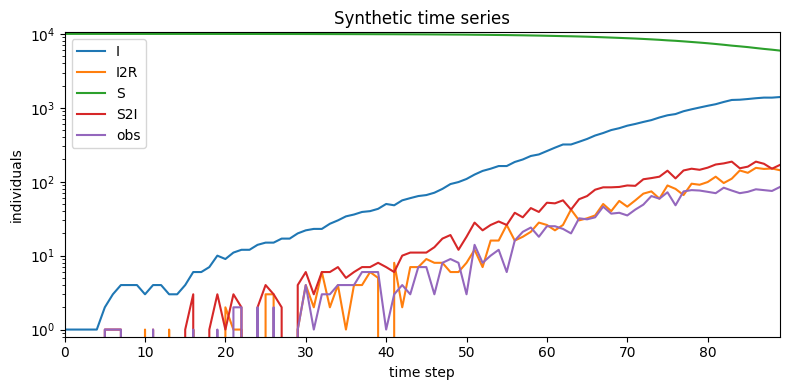

In [5]:
plt.figure(figsize=(8,4))
for name, value in sorted(synth_data.items()):
    if value.dim():
        plt.plot(value, label=name)
plt.xlim(0, len(empty_data) - 1)
plt.ylim(0.8, None)
plt.xlabel("time step")
plt.ylabel("individuals")
plt.yscale("log")
plt.legend(loc="best")
plt.title("Synthetic time series")
plt.tight_layout()

## Inference  <a class="anchor" id="Inference"></a>

Next let's recover estimates of the latent variables given only observations `obs`. To do this we'll create a new model instance from the synthetic observations.

In [6]:
obs = synth_data["obs"]
model = SimpleSIRModel(population, recovery_time, obs)

The `CompartmentalModel` provides a number of inference algorithms. The cheapest and most scalable algorithm is SVI, avilable via the `.fit_svi()` method. This method returns a list of losses to help us diagnose convergence; the fitted parameters are stored in the model object.

In [7]:
%%time
losses = model.fit_svi(num_steps=101 if smoke_test else 2001,
                       jit=True)

INFO 	 Heuristic init: R0=1.83, rho=0.546
INFO 	 Running inference...
INFO 	 step 0 loss = 6.808
INFO 	 step 200 loss = 8.604
INFO 	 step 400 loss = 6.422
INFO 	 step 600 loss = 4.164
INFO 	 step 800 loss = 3.386
INFO 	 step 1000 loss = 3.262
INFO 	 step 1200 loss = 3.124
INFO 	 step 1400 loss = 3.046
INFO 	 step 1600 loss = 3.027
INFO 	 step 1800 loss = 3.05
INFO 	 step 2000 loss = 3.016
INFO 	 SVI took 12.9 seconds, 155.2 step/sec


CPU times: user 13.3 s, sys: 211 ms, total: 13.5 s
Wall time: 13.5 s


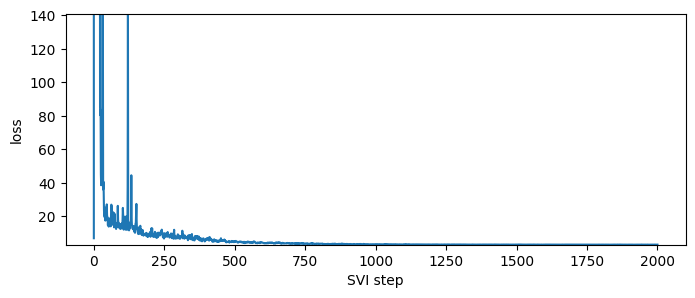

In [8]:
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("loss")
plt.ylim(min(losses), max(losses[50:]));

After inference, samples of latent variables are stored in the `.samples` attribute. These are primarily for internal use, and do not contain the full set of latent variables.

In [9]:
for key, value in sorted(model.samples.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

R0.shape = (100, 1)
auxiliary.shape = (100, 1, 2, 90)
rho.shape = (100, 1)


## Prediction  <a class="anchor" id="Prediction"></a>

After inference we can both examine latent variables and forecast forward using the [.predict()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.predict) method. First let's simply predict latent variables.

In [10]:
%%time
samples = model.predict()

INFO 	 Predicting latent variables for 90 time steps...


CPU times: user 143 ms, sys: 3.99 ms, total: 147 ms
Wall time: 147 ms


In [11]:
for key, value in sorted(samples.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

I.shape = (100, 90)
I2R.shape = (100, 90)
R0.shape = (100, 1)
S.shape = (100, 90)
S2I.shape = (100, 90)
auxiliary.shape = (100, 1, 2, 90)
obs.shape = (100, 90)
rho.shape = (100, 1)


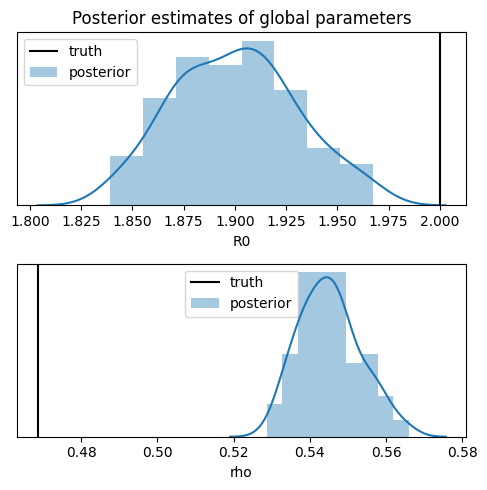

In [12]:
names = ["R0", "rho"]
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    truth = synth_data[name]
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(truth, color="k", label="truth")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
plt.tight_layout()

Notice that while the inference recovers the basic reproductive number `R0`, it poorly estimates the response rate `rho` and underestimates its uncertainty. While perfect inference would provide better uncertainty estimates, the response rate is known to be difficult to recover from data. Ideally the model can either incorporate a narrower prior, either obtained by testing a random sample of the population, or by more accurate observations, e.g. counting deaths rather than confirmed infections.

## Forecasting  <a class="anchor" id="Forecasting"></a>

We can forecast forward by passing a `forecast` argument to the `.predict()` method, specifying the number of time steps ahead we'd like to forecast. The returned `sample` will contain time values during both the first observed time interval (here 90 days) and the forecasted window (say 30 days).

In [13]:
%time
samples = model.predict(forecast=30)

INFO 	 Predicting latent variables for 90 time steps...
INFO 	 Forecasting 30 steps ahead...


CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs


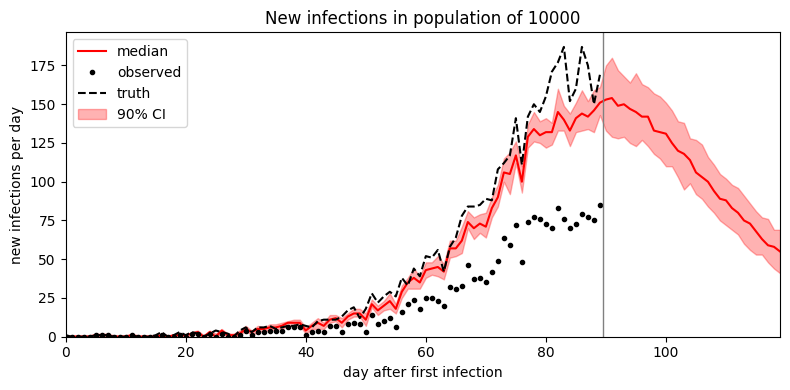

In [14]:
def plot_forecast(samples):
    duration = len(empty_data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])

    time = torch.arange(duration + forecast)
    S2I = samples["S2I"]
    median = S2I.median(dim=0).values
    p05 = S2I.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2I.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    plt.figure(figsize=(8, 4))
    plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    plt.plot(time, median, "r-", label="median")
    plt.plot(time[:duration], obs, "k.", label="observed")
    plt.plot(time[:duration], synth_data["S2I"], "k--", label="truth")
    plt.axvline(duration - 0.5, color="gray", lw=1)
    plt.xlim(0, len(time) - 1)
    plt.ylim(0, None)
    plt.xlabel("day after first infection")
    plt.ylabel("new infections per day")
    plt.title("New infections in population of {}".format(population))
    plt.legend(loc="upper left")
    plt.tight_layout()

plot_forecast(samples)

It looks like the mean field guide underestimates uncertainty. To improve uncertainty estimates we can instead try MCMC inference. In this simple model MCMC is only a small factor slower than SVI; in more complex models MCMC can be multiple orders of magnitude slower than SVI.

In [15]:
%%time
model = SimpleSIRModel(population, recovery_time, obs)
mcmc = model.fit_mcmc(num_samples=4 if smoke_test else 400,
                      haar_full_mass=10, jit_compile=True)

INFO 	 Running inference...
Sample: 100%|██████████| 800/800 [01:44,  7.66it/s, step size=1.17e-01, acc. prob=0.853]

CPU times: user 1min 43s, sys: 1.14 s, total: 1min 44s
Wall time: 1min 44s


INFO 	 Predicting latent variables for 90 time steps...
INFO 	 Forecasting 30 steps ahead...


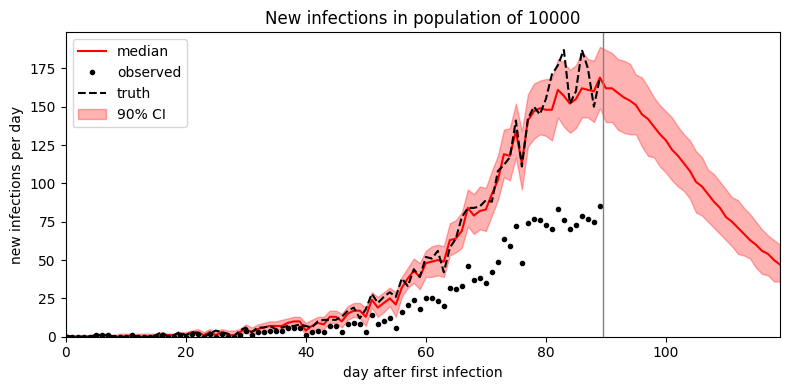

In [16]:
samples = model.predict(forecast=30)
plot_forecast(samples)